<a href="https://colab.research.google.com/github/fhfmendes04/Awesome-LLM/blob/main/Tatui_Trainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q accelerate peft bitsandbytes transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.7/320.7 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 5.4 MB/s eta 0:00:00


In [ ]:
!pip install -q sentencepiece tokenizers datasets trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.6/316.6 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.8/109.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.4 MB/s eta 0:00:00


In [ ]:
# Imports
import os
import torch
import datasets
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from copy import deepcopy
import random
from datasets import load_dataset, Dataset, DatasetDict
from transformers import (AutoModelForCausalLM,
                          AutoTokenizer,
                          BitsAndBytesConfig,
                          HfArgumentParser,
                          TrainingArguments,
                          DataCollatorForLanguageModeling,
                          pipeline,
                          Trainer,
                          logging)
from peft import LoraConfig, PeftModel, get_peft_model,prepare_model_for_kbit_training
from trl import SFTTrainer
import warnings
import wandb
warnings.filterwarnings('ignore')
seed = 42
#torch.manual_seed(seed)

In [ ]:
# Define o nível de log para CRITICAL
logging.set_verbosity(logging.CRITICAL)
os.environ['WANDB_DISABLED'] = 'true'
wandb.init(mode='disabled')

In [ ]:
# Especifica o diretório de trabalho
caminho = "/content/drive/MyDrive/USP/Mestrado Sistema de Informação/Pesquisa/code"
os.chdir(caminho)
print(os.getcwd())


/content/drive/MyDrive/USP/Mestrado Sistema de Informação/Pesquisa/code


In [ ]:
# Verifica o modelo da GPU
if torch.cuda.is_available():
    print('Número de GPUs:', torch.cuda.device_count())
    print('Modelo GPU:', torch.cuda.get_device_name(0))
    print('Total Memória [GB] da GPU:',torch.cuda.get_device_properties(0).total_memory / 1e9)

Número de GPUs: 1
Modelo GPU: Tesla T4
Total Memória [GB] da GPU: 15.835660288


In [ ]:
# Nome do repositório do LLM pré-treinado
repositorio_hf = "openai-community/gpt2" #""NousResearch/Llama-2-7"

# Nome do novo modelo
#modelo_dsa = "novo_modelo_dsa"

## Datasets

In [ ]:
def tabular_to_text(dado, colunas, sequencial=False):
  frase = "|"
  tamanho = len(colunas)
  if sequencial:
    for t in range(tamanho):
      c = colunas[t]
      d = dado[t]
      palavra = f'{c} -> {str(d)}| '
      frase += palavra
  else:
    col = deepcopy(colunas)
    flag = True
    while flag:
      selected_item = random.choice(col)
      col.remove(selected_item)
      t = colunas.index(selected_item)
      d = dado[t]
      palavra = f'{selected_item} -> {str(d)}| '
      frase += palavra
      if len(col) == 0:
        flag = False
  return frase

In [ ]:
#pasta = "./data/GiveMeSomeCredit/"
pasta = "./data/Adult/"

arquivo = "adult.csv"

In [ ]:
df = pd.read_csv(pasta + arquivo)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [ ]:
# Missing
df.isnull().sum()

,0
age,0
workclass,0
fnlwgt,0
education,0
educational-num,0
marital-status,0
occupation,0
relationship,0
race,0
gender,0


In [ ]:
df['income'].value_counts()

,count
income,
<=50K,37155
>50K,11687


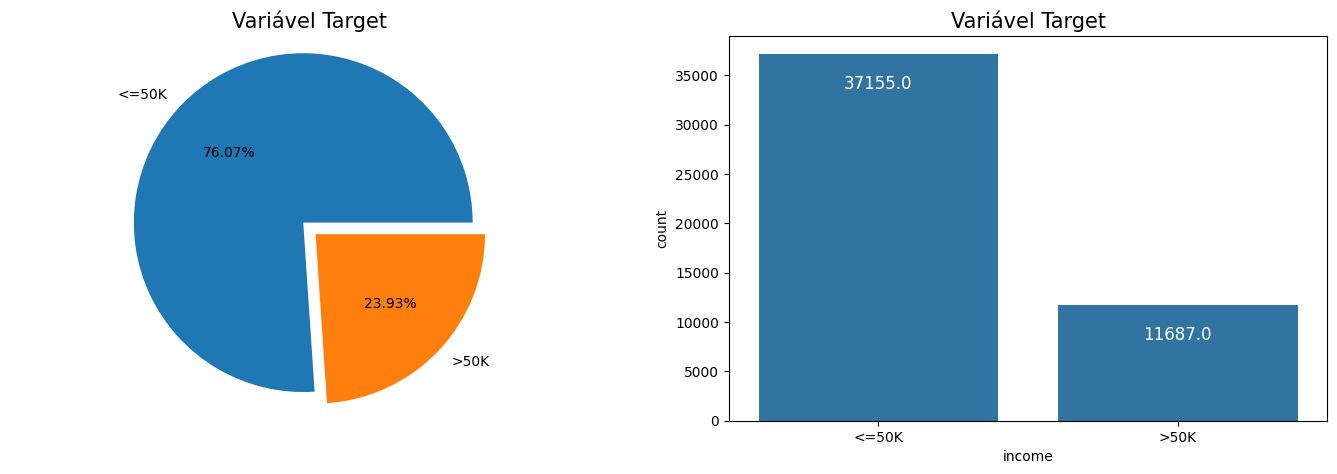

In [ ]:
# Figura
plt.figure(figsize = (17,(100)/20))

plt.subplot(121)

plt.pie(round(df['income'].value_counts() / len(df) * 100, 2),
        labels = list(df['income'].value_counts().index),
        autopct = "%.2f%%",
        explode = (0,0.1))

plt.axis("equal")
plt.title("Variável Target", size = 15)

plt.subplot(122)
ax = sns.countplot(data = df, x = 'income')
plt.title("Variável Target", fontsize = 15)
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}',
                (p.get_x()+0.4,
                 p.get_height()),
                ha = 'center',
                va = 'top',
                color = 'white',
                size = 12)

In [ ]:
 "<s>#### " + str(tabular_to_text(list(df.iloc[1].values), feature, sequencial=False)) + " #####<s>"

'<s>#### |gender -> Male| relationship -> Husband| fnlwgt -> 89814| capital-gain -> 0| educational-num -> 9| native-country -> United-States| marital-status -> Married-civ-spouse| occupation -> Farming-fishing| workclass -> Private| age -> 38| capital-loss -> 0| income -> <=50K| race -> White| education -> HS-grad| hours-per-week -> 50|  #####<s>'

In [ ]:
df_text = []
tamanho = len(df)
for i in tqdm(range(tamanho)):
  df_text.append("<s>#### " + str(tabular_to_text(list(df.iloc[i].values), feature, sequencial=False)) + " #####<s>")


df_text = pd.DataFrame(df_text[:10000])#tamanho de teste
df_text.columns = ["text"]

train_set = df_text.sample(frac=0.8, random_state=seed)
test_set = df_text.drop(train_set.index)


dataset_treino = Dataset.from_pandas(train_set)
dataset_treino = DatasetDict({'train': dataset_treino})
#dataset_treino = dataset_treino['train'].remove_columns('__index_level_0__')
dataset_treino

100%|██████████| 48842/48842 [00:08<00:00, 5672.04it/s] 


DatasetDict({
    train: Dataset({
        features: ['text', '__index_level_0__'],
        num_rows: 8000
    })
})

In [ ]:
dataset_teste = Dataset.from_pandas(test_set)
dataset_teste = DatasetDict({'test': dataset_teste})
#dataset_teste = dataset_teste['test'].remove_columns('__index_level_0__')
dataset_teste

DatasetDict({
    test: Dataset({
        features: ['text', '__index_level_0__'],
        num_rows: 2000
    })
})

In [ ]:
import matplotlib.pyplot as plt

def plot_data_lengths(dataset_treino, dataset_teste):
    lengths = [len(x['text']) for x in dataset_treino]
    lengths += [len(x['text']) for x in dataset_teste]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Tamanho da entrada')
    plt.ylabel('Frequencia')
    #plt.title('DTamanho das entradas')
    plt.show()

1000


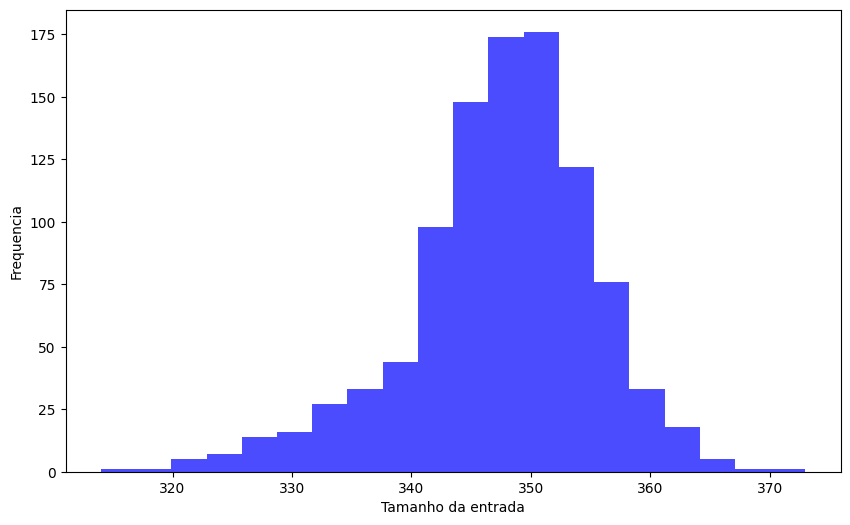

In [ ]:
plot_data_lengths(dataset_treino['train'], dataset_teste['test'])

## Definindo os Parâmetros de Configuração

In [ ]:
# Parâmetros LoRA
lora_r = 32
lora_alpha = 16
lora_dropout = 0.1

In [ ]:
# Parâmetros bitsandbytes (QLoRa)
use_4bit = True
bnb_4bit_compute_dtype = "float16"
bnb_4bit_quant_type = "nf4"
use_nested_quant = False

In [ ]:
# Parâmetros do ajuste fino
output_dir = "saida"
num_train_epochs = 5 #EPOCHS
fp16 = True
bf16 = False
per_device_train_batch_size = 1 #4
per_device_eval_batch_size = 1  #4
gradient_accumulation_steps = 1
gradient_checkpointing = True
max_grad_norm = 0.3
learning_rate = 2e-4
weight_decay = 0.001
optim = "paged_adamw_32bit"
lr_scheduler_type = "cosine"
max_steps = -1
warmup_ratio = 0.03

In [ ]:
# Agrupando sequências em lotes de mesmo comprimento
group_by_length = True
save_steps = 0
logging_steps = 400

In [ ]:
# Precisão dos dados para treinamento
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

In [ ]:
# Definindo os parâmetros da quantização
bnb_config = BitsAndBytesConfig(load_in_4bit = use_4bit,
                                bnb_4bit_quant_type = bnb_4bit_quant_type,
                                bnb_4bit_compute_dtype = compute_dtype,
                                bnb_4bit_use_double_quant = use_nested_quant)

## Modelo Pré-Treinado

In [ ]:
# Carregando o modelo base pré-treinado
modelo = AutoModelForCausalLM.from_pretrained(repositorio_hf,
                                              quantization_config = bnb_config,
                                              #trust_remote_code=True,
                                              #use_auth_token=True,
                                              device_map = "auto")

In [ ]:
# Não usaremos o cache
modelo.config.use_cache = False
modelo.config.pretraining_tp = 1

In [ ]:
# Carregando o tokenizador do modelo base
tokenizador = AutoTokenizer.from_pretrained(repositorio_hf, trust_remote_code = True) #padding_side="left"
tokenizador.pad_token = tokenizador.eos_token
tokenizador.padding_side = "right"

In [ ]:
def tokenize_function(info):
    return tokenizador(info["text"], padding="max_length", truncation=True, max_length=1024)

In [ ]:
# Tokenize the dataset
tokenized_train_dataset = dataset_treino.map(tokenize_function, batched=True)

print(f"Original dataset columns: {dataset_treino.column_names}")
print(f"Tokenized dataset columns: {tokenized_train_dataset.column_names}")

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Original dataset columns: {'train': ['text', '__index_level_0__']}
Tokenized dataset columns: {'train': ['text', '__index_level_0__', 'input_ids', 'attention_mask']}


In [ ]:
# Tokenize the dataset
tokenized_test_dataset = dataset_teste.map(tokenize_function, batched=True)

print(f"Original dataset columns: {dataset_teste.column_names}")
print(f"Tokenized dataset columns: {tokenized_test_dataset.column_names}")

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Original dataset columns: {'test': ['text', '__index_level_0__']}
Tokenized dataset columns: {'test': ['text', '__index_level_0__', 'input_ids', 'attention_mask']}


## Ajuste-Fino

In [ ]:
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizador,
    mlm=False)

In [ ]:
# Carregando a configuração LoRA
peft_config = LoraConfig(lora_alpha = lora_alpha,
                         lora_dropout = lora_dropout,
                         r = lora_r,
                         bias = "none",
                         task_type = "CAUSAL_LM")

In [ ]:
# Definindo os parâmetros de treino
training_arguments = TrainingArguments(output_dir = output_dir,
                                       num_train_epochs = num_train_epochs,
                                       per_device_train_batch_size = per_device_train_batch_size,
                                       gradient_accumulation_steps = gradient_accumulation_steps,
                                       optim = optim,
                                       save_steps = save_steps,
                                       logging_steps = logging_steps,
                                       learning_rate = learning_rate,
                                       weight_decay = weight_decay,
                                       fp16 = fp16,
                                       bf16 = bf16,
                                       report_to=None,
                                       max_grad_norm = max_grad_norm,
                                       max_steps = max_steps,
                                       warmup_ratio = warmup_ratio,
                                       group_by_length = group_by_length,
                                       lr_scheduler_type = lr_scheduler_type)

In [ ]:
# Prepare the model for fine-tuning
modelo = prepare_model_for_kbit_training(modelo)

# Enable gradient checkpointing to save memory
modelo.gradient_checkpointing_enable()

# Apply LoRA to the base model
peft_model = get_peft_model(modelo, peft_config)

In [ ]:
trainer = Trainer(
    model=peft_model,
    args=training_arguments,
    train_dataset=tokenized_train_dataset['train'],
    eval_dataset=tokenized_test_dataset['test'],
    data_collator=data_collator,
    tokenizer=tokenizador,
)

In [163]:
%%time
#wandb.init(project="tabular", name="fhfmendes")
modelo.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

{'loss': 4.2779, 'grad_norm': 1.4332919120788574, 'learning_rate': 6.633333333333334e-05, 'epoch': 0.05}
{'loss': 1.8341, 'grad_norm': 1.5346657037734985, 'learning_rate': 0.000133, 'epoch': 0.1}
{'loss': 1.139, 'grad_norm': 2.0102686882019043, 'learning_rate': 0.00019966666666666668, 'epoch': 0.15}
{'loss': 0.9945, 'grad_norm': 1.8102952241897583, 'learning_rate': 0.00019994807997915655, 'epoch': 0.2}
{'loss': 0.917, 'grad_norm': 2.1648926734924316, 'learning_rate': 0.00019979132953554024, 'epoch': 0.25}
{'loss': 0.8491, 'grad_norm': 1.7467865943908691, 'learning_rate': 0.00019952991176752863, 'epoch': 0.3}
{'loss': 0.8338, 'grad_norm': 1.1467338800430298, 'learning_rate': 0.00019916410086626084, 'epoch': 0.35}
{'loss': 0.8172, 'grad_norm': 1.0085489749908447, 'learning_rate': 0.00019869428051685718, 'epoch': 0.4}
{'loss': 0.8118, 'grad_norm': 1.269661784172058, 'learning_rate': 0.0001981209434959862, 'epoch': 0.45}
{'loss': 0.7877, 'grad_norm': 1.0456310510635376, 'learning_rate': 0.

TrainOutput(global_step=40000, training_loss=0.7120449123382568, metrics={'train_runtime': 6779.4189, 'train_samples_per_second': 5.9, 'train_steps_per_second': 5.9, 'train_loss': 0.7120449123382568, 'epoch': 5.0})

In [164]:
trainer.evaluate()

{'eval_loss': 0.5783839225769043, 'eval_runtime': 96.1794, 'eval_samples_per_second': 20.794, 'eval_steps_per_second': 2.599, 'epoch': 5.0}


{'eval_loss': 0.5783839225769043,
 'eval_runtime': 96.1794,
 'eval_samples_per_second': 20.794,
 'eval_steps_per_second': 2.599,
 'epoch': 5.0}

In [263]:
# Salvando o modelo treinado
# Salva modelo e tokenizador
modelo.save_pretrained(f"ajuste_fino_{dataset_train.num_rows['train']}_{num_train_epochs}")
tokenizador.save_pretrained(f"ajuste_fino_{dataset_train.num_rows['train']}_{num_train_epochs}")

('ajuste_fino_800_5/tokenizer_config.json',
 'ajuste_fino_800_5/special_tokens_map.json',
 'ajuste_fino_800_5/vocab.json',
 'ajuste_fino_800_5/merges.txt',
 'ajuste_fino_800_5/added_tokens.json',
 'ajuste_fino_800_5/tokenizer.json')

In [265]:
# Carrega o modelo treinado
# Cria o pipeline
pipe = pipeline(task = "text-generation",
                model = "ajuste_fino_800_5",
                tokenizer = tokenizador,
                max_length = 200)

# Pipeline

In [172]:
import random

def escolhe_coluna(txt, feat, quantidade = 1):
  flag = True

  if (quantidade <= 0) or (quantidade > len(feature)):
      quantidade = 1

  quant_linha = txt.num_rows
  linha = random.randint(0, quant_linha)
  txt = txt['text'][linha]

  while flag:
    palavra = ''
    conta = 1
    while conta <= quantidade:
      c = random.choice(feat)
      x = txt.find(c)
      if x == -1:
        print("Faltou")
        flag = True
      else:
        flag = False
        t = txt[x:]
        x = t.find('|')
        t = t[:x]
        x = txt.find('->')
        if x == -1:
          print("Faltou -> ")
          flag = True
        else:
          flag = False
          palavra += '|' + t
          #feat.remove(c)
          conta += 1
  #print(palavra + '|')
  return palavra + '|'

In [283]:
def text_to_tabular(txt, feature):
  #x = txt.find("####<s>")
  #t = txt[:x+7]
  no_find = []
  palavra = ''
  flag = True
  for c in feature:
    x = txt.find(c)
    if x == -1:
      no_find.append(c)
      flag = False
      continue
    else:
      t = txt[x:]
      x = t.find("|")
      t = t[:x]
      x = t.find("->")
      if x == -1:
        no_find.append(c)
        flag = False
        continue
      else:
        palavra += "|" + t
  palavra += "|"
  if len(no_find) > 0:
    print(f'Faltou:{no_find}')
  # Executa o pipeline e extrai o resultado
    palavra = embaralha_prompt(palavra, feature)
    Resultado = pipe(f"<s>#### {palavra}") #####<s>") ####
    txt = resultado[0]['generated_text']
    no_find_2 = []
    for c in no_find:
      x = txt.find(c)
      if x == -1:
        no_find_2.append(c)
        flag = False
      else:
        t = txt[x:]
        x = t.find("|")
        t = t[:x]
        x = t.find("->")
        if x == -1:
          no_find_2.append(c)
          flag = False
        else:
          palavra += "|" + t
          #print(t)
      #palavra += "|"
      #print(no_find_2)
  return palavra, flag
#text_to_tabular(resultado[0]['generated_text'], feature)

In [270]:
# Pipeline com o Modelo Ajustado
pipe = pipeline(task = "text-generation",
                model = modelo,
                tokenizer = tokenizador,
                max_length =200)

In [269]:
# Uma Coluna
prompt = '|marital-status -> Married-civ-spouse|'
# Executa o pipeline e extrai o resultado
resultado = pipe(f"<s>#### {prompt} ####<s>")
print(resultado)
R1 = text_to_tabular(resultado[0]['generated_text'], feature)
print(R1)

[{'generated_text': '<s>#### |marital-status -> Married-civ-spouse| ####<s>#### race -> White| fnlwgt -> 97313| capital-gain -> 0| gender -> Male| productivity -> 50| education -> HS-grad| age -> 47| occupation -> Adm-clerical| educational-num -> 9| native-country -> United-States| workclass -> State-gov| capital-loss -> 0| relationship -> Husband| income -> >50K|  #####<s>####<s>####<s>####<s>####<s>####<s>####<s>####|  #####<s>####|  #####<s>####|  #####<s>####@@@@|  #####<s>####|  #####<s>####|  #####<s>####|  #####<s>####|  #####<s> #####<s> #####49'}]
Faltou:['hours-per-week']
['hours-per-week']
('|age -> 47|workclass -> State-gov|fnlwgt -> 97313|education -> HS-grad|educational-num -> 9|marital-status -> Married-civ-spouse|occupation -> Adm-clerical|relationship -> Husband|race -> White|gender -> Male|capital-gain -> 0|capital-loss -> 0|native-country -> United-States|income -> >50K|', False)


In [194]:
# Duas colunas
prompt = '|marital-status -> Married-civ-spouse|occupation -> Adm-clerical|'
# Executa o pipeline e extrai o resultado
resultado = pipe(f"<s>#### {prompt} ####<s>")
print(resultado)
R2 = text_to_tabular(resultado[0]['generated_text'], feature)
print(R2)

[{'generated_text': '<s>#### |marital-status -> Married-civ-spouse|occupation -> Adm-clerical| ####<s> <income -> <=50K| educational-num -> 9| hours-per-week -> 40| capital-loss -> 0| relationship -> Husband| race -> White| capital-gain -> 0| income -> <=50K| fnlwgt -> 111883| native-country -> United-States| gender -> Male| education -> HS-grad|  #####<s>####<s>####<s>####<s>####<s>####@@<s>####|  #####<s>####|  #####<s>####|  #####<s>####|  #####<s>####|  #####<s>####@@@@@@|  #####<s>####|  #####<s>####|  #####<s>####|  #####<s>####'}]
Faltou:['age', 'workclass']
<s>#### |marital-status -> Married-civ-spouse|occupation -> Adm-clerical| ####<s> <income -> <=50K| educational-num -> 9| hours-per-week -> 40| capital-loss -> 0| relationship -> Husband| race -> White| capital-gain -> 0| income -> <=50K| fnlwgt -> 111883| native-country -> United-States| gender -> Male| education -> HS-grad|  #####<s>####<s>####<s>####<s>####<s>####@@<s>####|  #####<s>####|  #####<s>####|  #####<s>####|  ##

In [ ]:
# Três colunas
prompt = '|Age -> 22| SSN -> 615-06-7821| Occupation -> Developer|'
# Executa o pipeline e extrai o resultado
resultado = pipe(f"<s>#### {prompt} ####<s>")
print(resultado)
R3 = text_to_tabular(resultado[0]['generated_text'], feature)
print(R3)

[{'generated_text': '<s>#### |Age -> 22| SSN -> 615-06-7821| Occupation -> Developer| ####<s>##### Annual_Income_Number -> 1358| Monthly_Inhand_Salary -> 3058.8| Num_Bank_Accounts -> 3| Num_Credit_Card -> 7| Interest_Rate -> 5| Num_of_Loan -> 3| Type_of_Loan -> None| Delay_from_due_date -> 17| Num_of_Delayed_Payment -> 13| Changed_Credit_Limit -> 4.54| Num_Credit_Inquiries -> 2.0| Credit_Mix -> Good| Outstanding_Debt -> 1138.47| Credit_Utilization_Ratio -> 25.59139718152417| Credit_History_Age -> None| Payment_of_Min_Amount -> NM| Total_EMI_per_month -> 43.9762547378097| Amount_invested_monthly -> 46.79792940302425| Payment_Behaviour -> High_spent_Medium_value_payments| Monthly_Balance -> 1082.29169580382058| Credit_Score -> Standard| ####<s>δ<s>$:/100%/| Monthly_Balance -> 818.65474929331712| Credit_Score -> Standard| ####<s>####<To><s>#<s>#<s>$:/8| Monthly_Energy_value_47.71639479975| Credit_Score -> Poor| #### ####<s>#987&AAA@839~8| #### ####<s>#<s>#534951853994978| Credit_Score -> 

In [ ]:
# Quatro colunas
prompt = '|Age -> 22| SSN -> 615-06-7821| Occupation -> Developer| Annual_Income -> 35547.71'
# Executa o pipeline e extrai o resultado
resultado = pipe(f"<s>[INST] {prompt}") # [/INST]<s>")
print(resultado)
R4 = text_to_tabular(resultado[0]['generated_text'], feature)
print(R4)

[{'generated_text': '<s>[INST] |Age -> 22| SSN -> 615-06-7821| Occupation -> Developer| Annual_Income -> 35547.71| Monthly_Inhand_Salary -> 066.9553333333333| Num_Bank_Accounts -> 3| Num_Credit_Card -> 3| Interest_Rate -> 6| Num_of_Loan -> 0| Type_of_Loan -> Mortgage Loan, and Auto Loan| Delay_from_due_date -> 8| Num_of_Delayed_Payment -> 13| Changed_Credit_Limit -> 7.6| Num_Credit_Inquiries -> 4.0| Credit_Mix -> Standard| Outstanding_Debt -> 861.29| Credit_Utilization_Ratio -> 26.7914772260895| Credit_History_Age -> 11 Years and 5 Months| Payment_of_Min_Amount -> No| Total_EMI_per_month -> 26.761935951818| Amount_invested_monthly -> 51.8447835552317| Payment_Behaviour -> High_spent_Small_value_payments| Monthly_Balance -> 898.281512691595| Credit_Score -> Poor| ####<s> About_Boss -> 34.34666989125544| Payment_Score -> Standard| ####<s>####<s>#####<s>0|####\\�8| ####<s>#<s>#&8| ####&8>##8| ####<s>#< ####<!>#8| ####<s>#####8| ####<!>#886| #####&8#9| ####9>##737| #####9'}]
Faltou_1: Name

In [289]:
def embaralha_prompt(txt, feature):
  quant = random.randint(1, int(len(feature) / 2))
  contador = 1
  fea = deepcopy(feature)
  while contador <= quant:
    flag = True
    while flag:
      c = random.choice(fea)
      x = txt.find(c)
      if x == -1:
        fea.remove(c)
      else:
        flag = False
    t = txt[x:]
    y = t.find('|')
    t = t[:(y+1)]
    contador += 1
    txt = txt.replace(t, '')
    if (random.randint(0, 1) == 0):
      txt = '|' + t[:-1] + txt
    else:
      txt = txt + t
  print('TXT:', txt)
  return txt
#embaralha_prompt(prompt, feature)

0

In [290]:
# Uma Coluna
posicao = True
escolhe = True
while posicao:
  if escolhe:
    quant = random.randint(1, 3)
    prompt = escolhe_coluna(dataset_teste['test'], feature, quant)
    print('Prompt: ', prompt)
  # Executa o pipeline e extrai o resultado
  resultado = pipe(f"<s>#### {prompt} ####<s>")
  prompt, escolhe = text_to_tabular(resultado[0]['generated_text'], feature)
  posicao = not escolhe
  prompt = embaralha_prompt(prompt, feature)
  #print('Continua: ',posicao)
  print('Resultado: ',prompt)
print('FIM')


Prompt:  |relationship -> Unmarried|age -> 38|race -> White|
Faltou:['workclass']
TXT: |relationship -> Unmarried|income -> <=50K|age -> 38|fnlwgt -> 245741|education -> Bachelors|educational-num -> 13|marital-status -> Divorced|occupation -> Exec-managerial|race -> White|gender -> Female|capital-gain -> 0|capital-loss -> 0|hours-per-week -> 60|native-country -> United-States|
TXT: |income -> <=50K|age -> 38|fnlwgt -> 245741|education -> Bachelors|educational-num -> 13|marital-status -> Divorced|occupation -> Exec-managerial|race -> White|capital-gain -> 0|hours-per-week -> 60|gender -> Female|native-country -> United-States|capital-loss -> 0|relationship -> Unmarried|
Resultado:  |income -> <=50K|age -> 38|fnlwgt -> 245741|education -> Bachelors|educational-num -> 13|marital-status -> Divorced|occupation -> Exec-managerial|race -> White|capital-gain -> 0|hours-per-week -> 60|gender -> Female|native-country -> United-States|capital-loss -> 0|relationship -> Unmarried|
Faltou:['workclas

KeyboardInterrupt: 

In [ ]:
# criar funcao text_to_pandas

## Métricas

In [ ]:
from collections import Counter
import nltk.translate.bleu_score as bleu


def calculate_BLEU(generated_summary, reference_summary, n):
    # Tokenize the generated summary and reference summary
    generated_tokens = generated_summary.split()
    reference_tokens = reference_summary.split()

    # Calculate the BLEU score
    weights = [1.0 / n] * n  # Weights for n-gram precision calculation
    bleu_score = bleu.sentence_bleu([reference_tokens], generated_tokens, weights=weights)

    return bleu_score


# Example usage
generated_summary = "The dog slept on the couch."
reference_summary = "The dog slept on te"
n = 2  # Bigram

bleu_score = calculate_BLEU(generated_summary, reference_summary, n)
print(f"BLEU-{n} score: {bleu_score}")

BLEU-2 score: 0.6324555320336759


In [ ]:
result = [R1, R2, R3, R4]
conta = 0
conta_2 = 0
for x in result:
  conta += 1
  for y in result:
    conta_2 += 1
    bleu_score = calculate_BLEU(x, y, n=2)
    print(f"BLEU-{n} R{conta}.R{conta_2} - score: {bleu_score}")

BLEU-2 R1.R1 - score: 1.0
BLEU-2 R1.R2 - score: 0.24333213169614382
BLEU-2 R1.R3 - score: 0.173421993904824
BLEU-2 R1.R4 - score: 0.2691262104723413
BLEU-2 R2.R5 - score: 0.239001141952869
BLEU-2 R2.R6 - score: 1.0
BLEU-2 R2.R7 - score: 0.23702391582353877
BLEU-2 R2.R8 - score: 0.20808978278463242
BLEU-2 R3.R9 - score: 0.17249323129229274
BLEU-2 R3.R10 - score: 0.23763541031440186
BLEU-2 R3.R11 - score: 1.0
BLEU-2 R3.R12 - score: 0.27815518971151965
BLEU-2 R4.R13 - score: 0.26920668352966776
BLEU-2 R4.R14 - score: 0.21351200388648786
BLEU-2 R4.R15 - score: 0.2808936228404366
BLEU-2 R4.R16 - score: 1.0


In [ ]:
from collections import Counter
import re


def calculate_ROUGE(generated_summary, reference_summary, n):
    # Tokenize the generated summary and reference summary into n-grams
    generated_ngrams = generate_ngrams(generated_summary, n)
    reference_ngrams = generate_ngrams(reference_summary, n)

    # Calculate the recall score
    matching_ngrams = len(set(generated_ngrams) & set(reference_ngrams))
    recall_score = matching_ngrams / len(reference_ngrams)

    return recall_score


def generate_ngrams(text, n):
    # Preprocess text by removing punctuation and converting to lowercase
    text = re.sub(r'[^\w\s]', '', text.lower())

    # Generate n-grams from the preprocessed text
    words = text.split()
    ngrams = [tuple(words[i:i+n]) for i in range(len(words) - n + 1)]

    return ngrams


# Example usage
generated_summary = "The dog slept on the couch."
reference_summary = "The dog slept on the couch."
n = 2  # bigram

rouge_score = calculate_ROUGE(generated_summary, reference_summary, n)
print(f"ROUGE-{n} score: {rouge_score}")

ROUGE-2 score: 1.0
